# Model Explain

整体分为两大模块，分别为机器学习模型的解释和深度模型的解释。

> 目前整体模型的解释核心均是基于`shap`包进行了封装

## 1. 机器学习模型

目前机器学习模型部分可供解释的模型主要为树模型，分别为XGBoost、LightGBM和RandomForest，对模型的解释主要为对样本预测的概率进行解释，将其分解到每个特征的得分上，特征得分越高则对增益越大，越小则增益越小。


下面以`lightgbm`模型为例进行讲解（`xgboost`和`RandomForest`模型和此方式完全一致）

In [1]:
# 构建数据集和训练

import lightgbm as lgb
from sklearn.model_selection import train_test_split
import shap

import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

X, y = shap.datasets.adult()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)  # 模型训练

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[683]	valid_0's binary_logloss: 0.277144


### 1.1 特征选取策略

对于训练好的模型做解释时，目的是选择对最终得分增益最高的特征，基于此想法，构建了四种不同的特征选取策略，分别为`max_shap`, `min_shap`,`abs_shap`,`threshold`。

#### 最大shap值
按照最大shap值策略进行top特征的选取，这种方式选取的特征代表**最大正向促进了最终样本的得分**。

In [2]:
from model_helper.model_explain import lgb_explain

pred = model.predict(X_test)  # 模型预测

reasons = lgb_explain(X_test, model, top_feature_num=2, strategy="max_shap")  # 每个样本取top2的最大shap值所应的特征，并返回特征的取值，将其拼接为字符串

print(f"最终生成的解释理由应该和预测样本量一致，预测样本量是{len(pred)}, 最终生成的解释理由量是{len(reasons)}, 前五个样本的解释理由为")
for i in range(5):
    print(f"第{i+1}个样本模型预测值为{pred[i]}，理由为'{reasons[i]}'")

/home/liuyongjie/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/liuyongjie/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


data columns num is 12, feature_group set None, so default feature group is 1, all columns. 12 features not in feature_meaning_dic,these features will use the feature name.
最终生成的解释理由应该和预测样本量一致，预测样本量是6513, 最终生成的解释理由量是6513, 前五个样本的解释理由为
第1个样本模型预测值为0.03967370348493667，理由为'Occupation value is 4.0,Age value is 39.0'
第2个样本模型预测值为0.6556555160466638，理由为'Hours per week value is 58.0,Age value is 48.0'
第3个样本模型预测值为0.04575937619782967，理由为'Marital Status value is 2.0,Relationship value is 4.0'
第4个样本模型预测值为0.012177821611011226，理由为'Sex value is 1.0,Occupation value is 4.0'
第5个样本模型预测值为0.3810618084187876，理由为'Relationship value is 4.0,Age value is 50.0'


#### 最小shap值

按照最小shap值策略进行top特征的选取，这种方式选取的特征代表**最大负向促进了最终样本的得分**。

In [3]:
from model_helper.model_explain import lgb_explain

pred = model.predict(X_test)  # 模型预测

reasons = lgb_explain(X_test, model, top_feature_num=2, strategy="min_shap")  # 每个样本取top2的最小shap值所应的特征，并返回特征的取值，将其拼接为字符串
print(f"最终生成的解释理由应该和预测样本量一致，预测样本量是{len(pred)}, 最终生成的解释理由量是{len(reasons)}, 前五个样本的解释理由为")
for i in range(5):
    print(f"第{i+1}个样本模型预测值为{pred[i]}，理由为'{reasons[i]}'")

data columns num is 12, feature_group set None, so default feature group is 1, all columns. 12 features not in feature_meaning_dic,these features will use the feature name.
最终生成的解释理由应该和预测样本量一致，预测样本量是6513, 最终生成的解释理由量是6513, 前五个样本的解释理由为
第1个样本模型预测值为0.03967370348493667，理由为'Sex value is 0.0,Relationship value is 1.0'
第2个样本模型预测值为0.6556555160466638，理由为'Capital Gain value is 0.0,Relationship value is 1.0'
第3个样本模型预测值为0.04575937619782967，理由为'Capital Gain value is 0.0,Age value is 22.0'
第4个样本模型预测值为0.012177821611011226，理由为'Relationship value is 0.0,Age value is 23.0'
第5个样本模型预测值为0.3810618084187876，理由为'Capital Gain value is 0.0,Hours per week value is 8.0'


#### shap绝对值

按照绝对值shap值策略进行top特征的选取，这种方式选取的特征代表**最大贡献促进了最终样本的得分**。

In [4]:
from model_helper.model_explain import lgb_explain

pred = model.predict(X_test)  # 模型预测

reasons = lgb_explain(X_test, model, top_feature_num=2, strategy="abs_shap")  # 每个样本取top2的绝对值shap值所应的特征，并返回特征的取值，将其拼接为字符串

print(f"最终生成的解释理由应该和预测样本量一致，预测样本量是{len(pred)}, 最终生成的解释理由量是{len(reasons)}, 前五个样本的解释理由为")

for i in range(5):
    print(f"第{i+1}个样本模型预测值为{pred[i]}，理由为'{reasons[i]}'")

data columns num is 12, feature_group set None, so default feature group is 1, all columns. 12 features not in feature_meaning_dic,these features will use the feature name.
最终生成的解释理由应该和预测样本量一致，预测样本量是6513, 最终生成的解释理由量是6513, 前五个样本的解释理由为
第1个样本模型预测值为0.03967370348493667，理由为'Age value is 39.0,Relationship value is 1.0'
第2个样本模型预测值为0.6556555160466638，理由为'Hours per week value is 58.0,Age value is 48.0'
第3个样本模型预测值为0.04575937619782967，理由为'Relationship value is 4.0,Age value is 22.0'
第4个样本模型预测值为0.012177821611011226，理由为'Relationship value is 0.0,Age value is 23.0'
第5个样本模型预测值为0.3810618084187876，理由为'Hours per week value is 8.0,Age value is 50.0'


#### 概率阈值

按照预测概率阈值进行top特征选取，如果概率大于设定的阈值，则该样本按照`max_shap`方式进行特征选取，否则按照`min_shap`方式进行特征的选取。

In [5]:
from model_helper.model_explain import lgb_explain

pred = model.predict(X_test)  # 模型预测

reasons = lgb_explain(X_test, model, top_feature_num=2, strategy="threshold", prob_threshold=0.5)

print(f"最终生成的解释理由应该和预测样本量一致，预测样本量是{len(pred)}, 最终生成的解释理由量是{len(reasons)}, 前五个样本的解释理由为")

for i in range(5):
    print(f"第{i+1}个样本模型预测值为{pred[i]}，理由为'{reasons[i]}'")

data columns num is 12, feature_group set None, so default feature group is 1, all columns. 12 features not in feature_meaning_dic,these features will use the feature name.
最终生成的解释理由应该和预测样本量一致，预测样本量是6513, 最终生成的解释理由量是6513, 前五个样本的解释理由为
第1个样本模型预测值为0.03967370348493667，理由为'Sex value is 0.0,Relationship value is 1.0'
第2个样本模型预测值为0.6556555160466638，理由为'Hours per week value is 58.0,Age value is 48.0'
第3个样本模型预测值为0.04575937619782967，理由为'Capital Gain value is 0.0,Age value is 22.0'
第4个样本模型预测值为0.012177821611011226，理由为'Relationship value is 0.0,Age value is 23.0'
第5个样本模型预测值为0.3810618084187876，理由为'Capital Gain value is 0.0,Hours per week value is 8.0'


### 1.2 特征分组

特征分组相当于输入特征按照业务或者其它规则分为不同的组，然后从不同的组中选取top shap值的特征，

分组形如`[("f1", "f2", "f3"), ("f4", "f5", "f6"), ("f7", "f8")]`，上面的方式相当于只有一个特征分区，里面包含全量的特征。
按照特征的分组的方式同样支持上面的四种特征选取策略，下面仅以一个例子为例其余参考上面即可。

In [6]:
from model_helper.model_explain import lgb_explain

feature_group = [("Age", "Sex", "Workclass"), ("Education-Num", "Marital Status", "Occupation", "Capital Loss"), ("Hours per week", "Capital Gain", "Relationship")]

reasons = lgb_explain(X_test, model, top_feature_num=2, strategy="max_shap", feature_group=feature_group)

print(f"最终生成的解释理由应该和预测样本量一致，预测样本量是{len(pred)}, 最终生成的解释理由量是{len(reasons)}, 前五个样本的解释理由为")

for i in range(5):
    print(f"第{i+1}个样本模型预测值为{pred[i]}，理由为'{reasons[i]}'")

data columns num is 12, feature_group num 3, contain feature num is 10.
in feature_group, 10 features not in feature_meaning_dic, these features will use the feature name.
最终生成的解释理由应该和预测样本量一致，预测样本量是6513, 最终生成的解释理由量是6513, 前五个样本的解释理由为
第1个样本模型预测值为0.03967370348493667，理由为'Age value is 39.0,Occupation value is 4.0'
第2个样本模型预测值为0.6556555160466638，理由为'Age value is 48.0,Education-Num value is 13.0'
第3个样本模型预测值为0.04575937619782967，理由为'Sex value is 1.0,Marital Status value is 2.0'
第4个样本模型预测值为0.012177821611011226，理由为'Sex value is 1.0,Occupation value is 4.0'
第5个样本模型预测值为0.3810618084187876，理由为'Age value is 50.0,Education-Num value is 13.0'


### 1.3 自定义输出格式

在上面输出中，默认输出的格式为`特征名+ value is 特征值`的 输出模式，可以自定义拼接方式。

In [7]:
feature_meaning_dic = {i: f"{i}_meaning" for i in X_test.columns}  # 特征名具体含义

def self_func(feature_value_pair, feature_meaning_dic):
    ret = []
    for feature, feature_value in feature_value_pair:
        feature_meaning = feature_meaning_dic.get(feature, feature)  # if no this key meaning, use key instead
        ret.append(f"{feature_meaning}: {feature_value}")
    return ",".join(ret)

feature_group = [("Age", "Sex", "Workclass"), ("Education-Num", "Marital Status", "Occupation", "Capital Loss"), ("Hours per week", "Capital Gain", "Relationship")] # 特征分组
reasons = lgb_explain(X_test, model, top_feature_num=2, strategy="max_shap", feature_group=feature_group, feature_meaning_dic=feature_meaning_dic, verbal_express=self_func)

print(f"最终生成的解释理由应该和预测样本量一致，预测样本量是{len(pred)}, 最终生成的解释理由量是{len(reasons)}, 前五个样本的解释理由为")

for i in range(5):
    print(f"第{i+1}个样本模型预测值为{pred[i]}，理由为'{reasons[i]}'")

data columns num is 12, feature_group num 3, contain feature num is 10.
最终生成的解释理由应该和预测样本量一致，预测样本量是6513, 最终生成的解释理由量是6513, 前五个样本的解释理由为
第1个样本模型预测值为0.03967370348493667，理由为'Age_meaning: 39.0,Occupation_meaning: 4.0'
第2个样本模型预测值为0.6556555160466638，理由为'Age_meaning: 48.0,Education-Num_meaning: 13.0'
第3个样本模型预测值为0.04575937619782967，理由为'Sex_meaning: 1.0,Marital Status_meaning: 2.0'
第4个样本模型预测值为0.012177821611011226，理由为'Sex_meaning: 1.0,Occupation_meaning: 4.0'
第5个样本模型预测值为0.3810618084187876，理由为'Age_meaning: 50.0,Education-Num_meaning: 13.0'


## 2. 深度模型解释

深度模型部分，目前分为两块一个是图像，另外一块是文本。

> 这部分主要测试的模型均是基于keras构建的

### 2.1 图像

图像部分支持最终输出层的ndim为2和3（包含batch_size维度）

In [8]:
# 手写数字图像识别，数据加载以及模型搭建和训练

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
activation='relu',
input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.Adadelta(),
metrics=['accuracy'])

model.fit(x_train, y_train,
batch_size=batch_size,
epochs=epochs,
verbose=1,
validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.summary()

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 123s 2ms/step - loss: 0.2700 - acc: 0.9178 - val_loss: 0.0611 - val_acc: 0.9804
Test loss: 0.06111625169534236
Test accuracy: 0.9804
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)        

#### 模型解释

目前解释部分的策略只有一种，对作出的预测 给出图形上的展示。

1/4 is processing...
	1/1 is plotting...
1/4 done, cost 1
2/4 is processing...
	1/1 is plotting...
2/4 done, cost 2
3/4 is processing...
	1/1 is plotting...
3/4 done, cost 1
4/4 is processing...
	1/1 is plotting...
4/4 done, cost 1


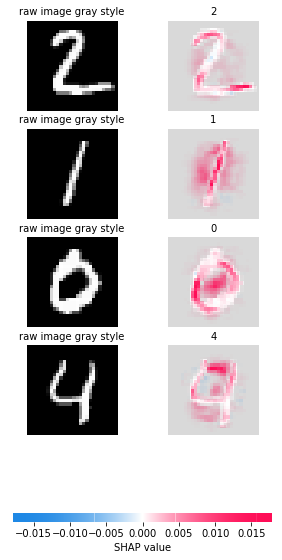

In [9]:
from model_helper.model_explain import explain_image_plot

# create backgroud sample, the more the sample number, the more accurate the plot 
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
fig, ax = explain_image_plot(x_test[1:5], model, background)  # 对其中四个样本作出解释

### 2.2 文本

图像部分支持最终输出层的ndim为2（包含batch_size维度）

In [10]:
# 文本分类数据加载和训练

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb


max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=1,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 47s 2ms/step
Test score: 0.4123319964790344
Test accuracy: 0.81592


#### 2.2.1 模型解释

解释部分最终可以分解为对最终的预测中，每个输入的词的一个得分。


#### 选取策略

类似机器学习模型解释部分的特征选取策略，这里分为四种`min`、`max`和`abs`和None（输出原始的整句话）。
返回的解释结果中是一个三元组，其中第一个为输入的文本（index或者word），第二为输入文本对应的shap值，最后一个为预测对应的index（预测类别对应的位置）

In [11]:
from model_helper.model_explain import explain_text_model


xx_test = x_test[:2]


r = explain_text_model(texts=xx_test, model=model, 
                       background_sample=x_train[:20], 
                       strategy="abs",
                       top_n_words=2)

print(f"共解释了{len(xx_test)}个样本")

for i in range(len(xx_test)):
    print(f"第{i+1}个样本：")
    print(r[i])

共解释了2个样本
第1个样本：
([179, 717], [0.055808417630123584, 0.04994702937033253], 0)
第2个样本：
([818, 472], [0.09124832981685813, -0.06742123246962137], 0)


#### 指定词典

上面部分得出的是对应的输入的index，可以输入对应的词典，key表示index，value表示对应的解释。

In [12]:
from model_helper.model_explain import explain_text_model


xx_test = x_test[:2]


words = imdb.get_word_index()
num2word = {}
for w in words.keys():
    num2word[words[w]] = w
num2word[0] = "padding"


r = explain_text_model(texts=xx_test, model=model, 
                       background_sample=x_train[:20], 
                       strategy="abs",
                       top_n_words=2, vocab_dic=num2word)

print(f"共解释了{len(xx_test)}个样本")

for i in range(len(xx_test)):
    print(f"第{i+1}个样本：")
    print(r[i])

共解释了2个样本
第1个样本：
(['world', 'sequence'], [0.055808417630123584, 0.04994702937033253], 0)
第2个样本：
(['realistic', '\x96'], [0.09124832981685813, -0.06742123246962137], 0)


#### padding index
可以指定对应的padding index是否解释。

In [13]:
from model_helper.model_explain import explain_text_model


xx_test = x_test[:2]


r = explain_text_model(texts=xx_test, model=model, 
                       background_sample=x_train[:20], 
                       strategy="abs",
                       explain_padding_index=False,
                       padding_index=0, 
                       top_n_words=2)

print(f"共解释了{len(xx_test)}个样本")

for i in range(len(xx_test)):
    print(f"第{i+1}个样本：")
    print(r[i])

共解释了2个样本
第1个样本：
([179, 717], [0.055808417630123584, 0.04994702937033253], 0)
第2个样本：
([818, 472], [0.09124832981685813, -0.06742123246962137], 0)
